# Gene regulatory analysis with pySCENIC

**This exercise has been largely borrowed from the pySCENIC [tutorial](https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html) and adapted to work with a dataset of [10X PBMCs](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3?) which you have downloaded with the course data. As it takes a long time run, we suggest if you are curious in the method to run it after the course**

Once single-cell genomics data has been processed, one can dissect important relationships between observed features in their genome context. In our genome, the activation of genes is controlled in the nucleus by the RNA transcriptional machinery, which activates local (promoters) or distal cis-regulatory elements (enhancers), to control the amount of RNA produced by every gene.

Conceptually, a Gene Regulatory Network (GRN) refers to a graph representation of how certain genes that control transcription i.e. “Transcription Factors” (TF) are in charge of directly controlling the transcription rates of their target genes (cis-regulation). At the same time, such target genes once activated, can be in charge of controlling other downstream target genes (trans-regulation). Computationally, methods that infer GRNs consider the co-variation of gene and chromatin accessibility features to identify modules that could be grouped and associated simultaneously with a few TFs. A group of genes controlled by the activity of the same TF is defined as a regulon.

In addition to co-variation, several methods have recognized the gathering and injection of prior knowledge data, such as the locations where a TF bind in the genome, or previously reported TF-target gene associations, to pre-define gene-gene edges that guide the inference of GRNs that are most-supported by that type of evidence.

The purpose of this exercise is to showcase the ability to infer information about gene regulatory networks using transcriptomic data alone: by pairing expression of transcription factors (TFs) with co-expressed genes, we can predict which genes are likely being activate by a particular TF in a specific cell population.

## [pySCENIC](https://scenic.aertslab.org/)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp

import seaborn as sns
import matplotlib.pyplot as plt
import glob

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/alex/anaconda3/e

### Load dataset

In [4]:
adata = sc.read_10x_h5("course_data/pbmc_10k_v3_filtered_feature_bc_matrix.h5")

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata.var_names_make_unique()

In [6]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [7]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


In [8]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [9]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

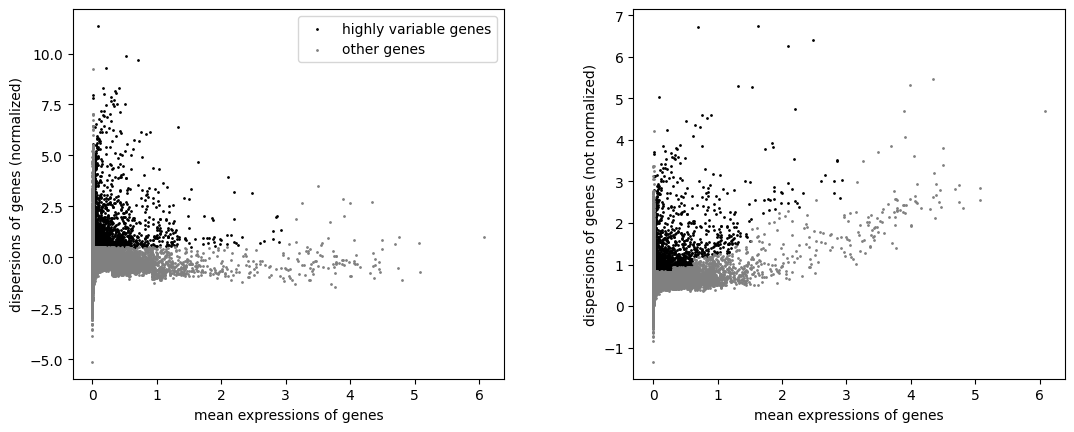

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [11]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

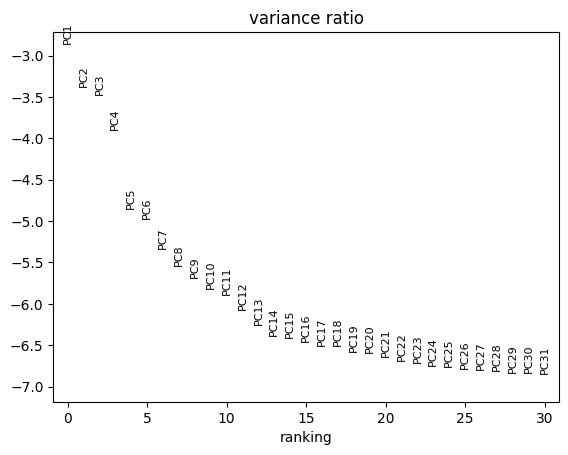

In [12]:
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


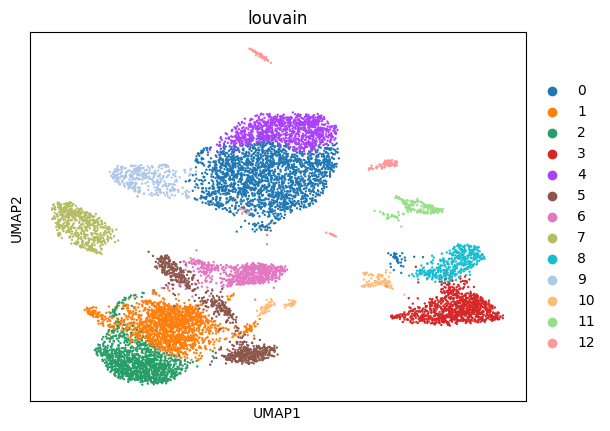

In [14]:
sc.tl.louvain(adata,resolution=0.4)
sc.pl.umap(adata, color=['louvain'] )

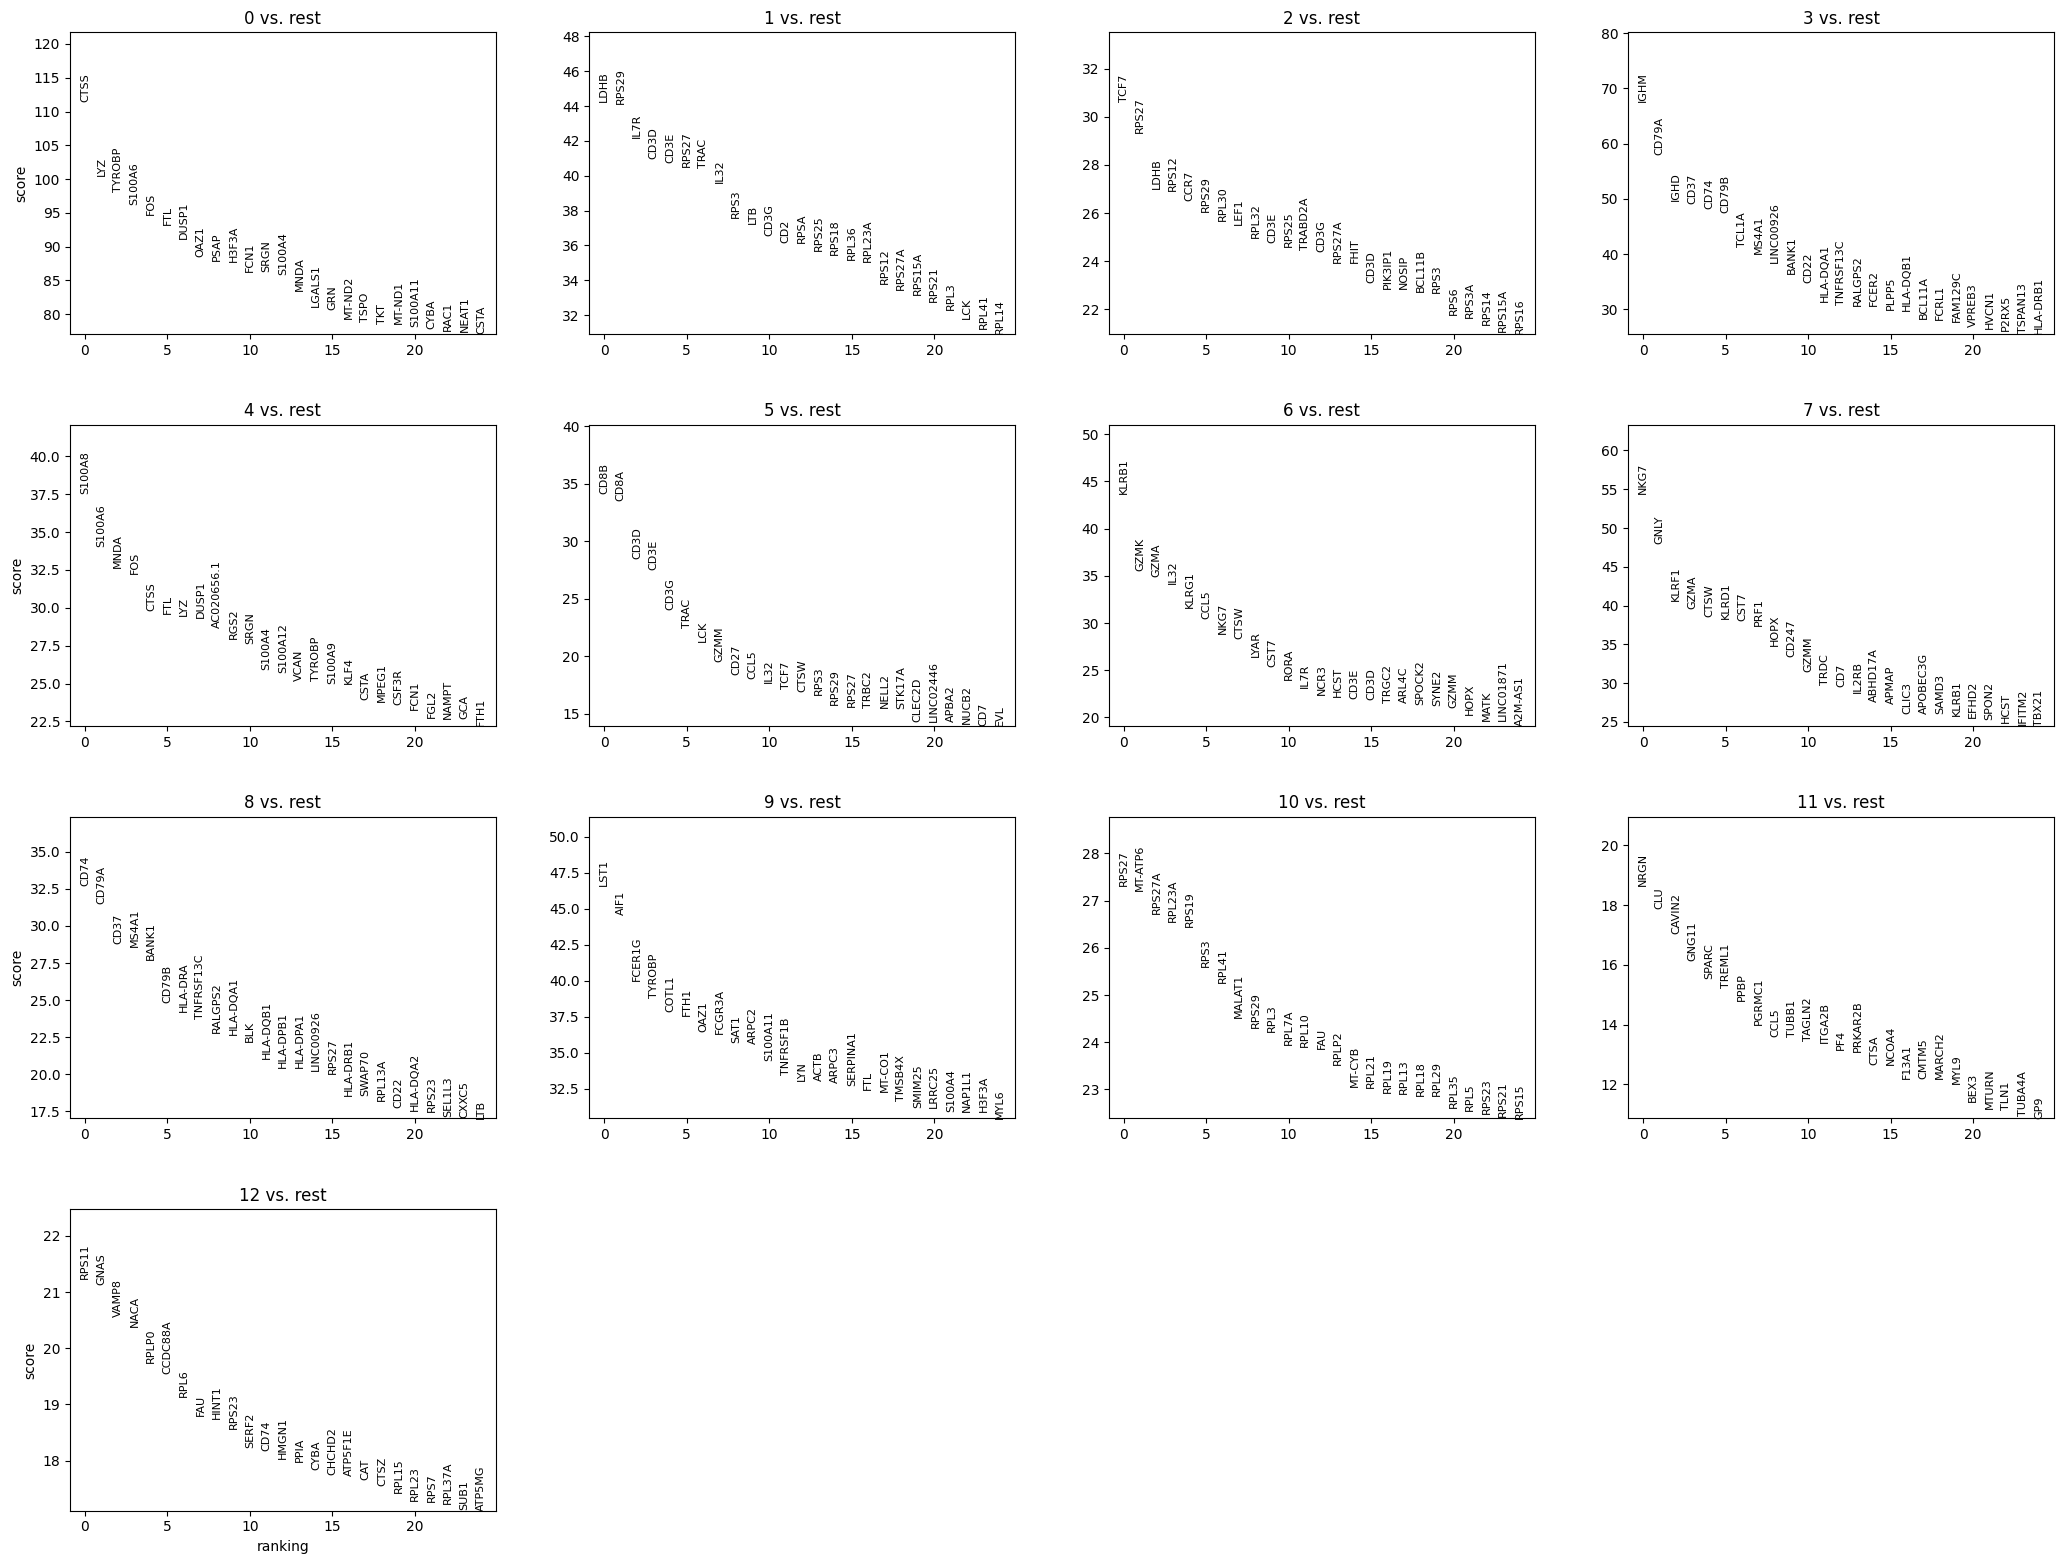

In [15]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

### Step 1: Gene regulatory network inference, and generation of co-expression modules
GRN inference using the GRNBoost2 algorithm: for this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.

Output: List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [16]:
## this file has to be downloaded if not found
!wget -nc https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt

File ‘allTFs_hg38.txt’ already there; not retrieving.



In [17]:
f_tfs = "allTFs_hg38.txt"
f_loom_path_scenic = "pbmc10k_filtered_scenic.loom"

In [18]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [19]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/alex/anaconda3/e

In [20]:
adjacencies = pd.read_csv("adj.csv", index_col=False)

Visualize the distribution of weights for general inspection of the quantiles and thresholds obtained from pyscenic. As provided by the pyscenic grn step, the importance scores follow a unimodal distribution, with negative/positive values indicating TF-gene associations with less/more importance, respectively. From the right-tail of this distribution, we can recover the most relevant interactions between TFs and potential target genes, supported by gene expression values and the analysis done by pyscenic.

In [38]:
adjacencies.head()

,TF,target,importance
0,CEBPD,VCAN,33.587173
1,ZEB2,LTB,33.086506
2,KLF4,VCAN,29.961844
3,CEBPD,SRGN,29.306472
4,MEF2C,HLA-DRA,28.519784


(-10.0, 10.0)

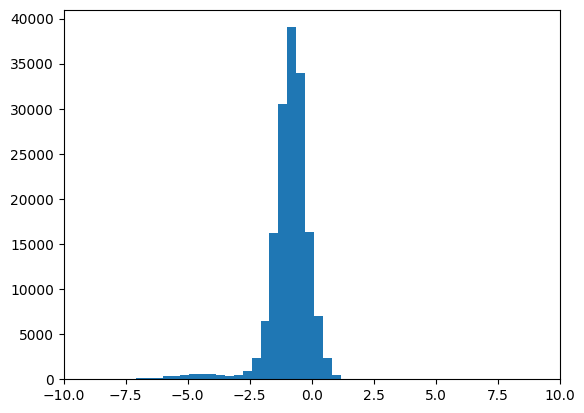

In [22]:
plt.hist(np.log10(adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

As targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes. Next, we use an annotation of TF associations to Transcription Start Sites (TSSs) to refine this annotation.

### Step 2-3: Regulon prediction aka cisTarget from CLI
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

Download TSS annotations precalculated by Aerts’s lab:

In [23]:
!wget -nc https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather

File ‘hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather’ already there; not retrieving.



In [24]:
# ranking databases
db_glob = "*feather"
db_names = " ".join(glob.glob(db_glob))

In [25]:
db_names

'hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather'

Download a catalog of motif-to-TF associations

In [26]:
!wget -nc https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

File ‘motifs-v9-nr.hgnc-m0.001-o0.0.tbl’ already there; not retrieving.



In [27]:
# motif databases
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [28]:
!pyscenic ctx adj.csv \
    'hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather' \
    --annotations_fname "motifs-v9-nr.hgnc-m0.001-o0.0.tbl" \
    --expression_mtx_fname "pbmc10k_filtered_scenic.loom" \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 3 > pyscenic_ctx_stdout.txt

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/alex/anaconda3/e

To explore the candidates reported, it is recommended as a rule of thumb to explore the output by the ranking of relative contribution, or by top-quantile thresholds defined visually to obtain a high signal-to-noise ratio.

### Define custom quantiles for further exploration

In [29]:
import numpy as np

n_genes_detected_per_cell = np.sum(adata.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01     136.0
0.05     155.0
0.10     169.0
0.50     237.0
1.00    1017.0
dtype: float64


The histogram below indicates the distribution of genes detected per cell. This visualization is convenient to define the parameter --auc_threshold in the next step. Specifically, the default parameter of --auc_threshold is 0.05, which in this plot would result in the selection of 144 genes, to be used as a reference per cell for AUCell calculations. The modification of this parameter affects the estimation of AUC values calculated by AUCell.

/tmp/ipykernel_279481/1384461256.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")


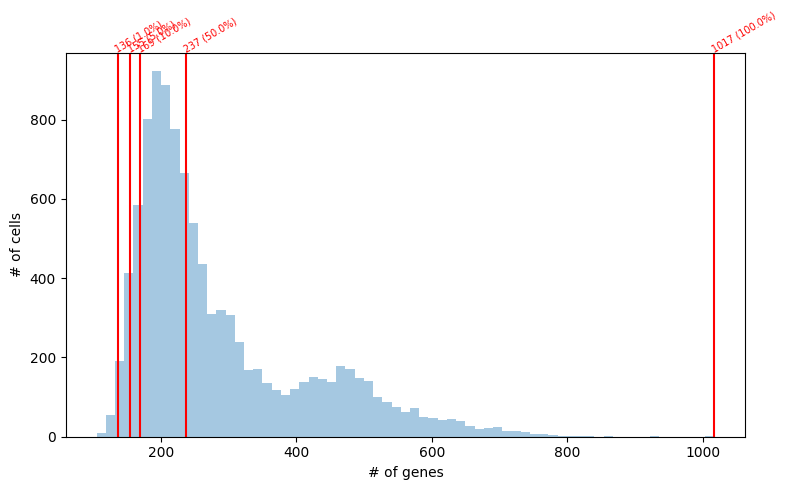

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

This step will use TFs to calculate Area Under the Curve scores, that summarize how well the gene expression observed in each cell can be associated by the regulation of target genes regulatred by the mentioned TFs.

Using the above-generated matrix of cell x TFs and those scores, we can calculate a new embedding using only those.

### Step 4: Cellular enrichment (aka AUCell) from CLI
It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [31]:
!pyscenic aucell "pbmc10k_filtered_scenic.loom" \
    "reg.csv" \
    --output "auc.csv" \
    --num_workers 3 > "pyscenic_aucell_stdout.txt"

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/alex/anaconda3/e

In [32]:
auc_df = pd.read_csv("auc.csv", index_col=0)

In [33]:
auc_df.head()

,ARID5B(+),BACH2(+),BATF(+),BCL11A(+),BCL6(+),CEBPB(+),CEBPD(+),CREB5(+),E2F1(+),E2F2(+),...,STAT1(+),TAL1(+),TBX21(+),TCF4(+),TCF7(+),TCF7L2(+),USF2(+),ZNF595(+),ZNF831(+),ZNF85(+)
Cell,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCGCCCAT-1,0.035164,0.000000,0.047850,0.013579,0.024272,0.018955,0.016766,0.026724,0.013183,0.036084,...,0.034538,0.017201,0.041977,0.000000,0.053187,0.015954,0.024688,0.035599,0.035599,0.000000
AAACCCACAGAGTTGG-1,0.004977,0.010264,0.023925,0.013579,0.156211,0.087353,0.074413,0.095586,0.005611,0.101618,...,0.049658,0.030772,0.017486,0.000000,0.000000,0.066439,0.006935,0.000000,0.000000,0.000000
AAACCCACAGGTATGG-1,0.015828,0.004716,0.176838,0.003637,0.000000,0.008990,0.030588,0.008107,0.023693,0.000000,...,0.011459,0.015724,0.082923,0.000000,0.000000,0.011178,0.000000,0.000000,0.049083,0.000000
AAACCCACATAGTCAC-1,0.087623,0.046325,0.000000,0.083342,0.000000,0.002954,0.003111,0.000000,0.013093,0.006796,...,0.000000,0.008041,0.011048,0.066163,0.000000,0.002572,0.034951,0.000000,0.026969,0.101942
AAACCCACATCCAATG-1,0.016399,0.046325,0.079404,0.006239,0.000871,0.009863,0.017225,0.005705,0.023158,0.000000,...,0.011141,0.005931,0.072210,0.012945,0.024905,0.021464,0.001664,0.000000,0.056634,0.037621


In [34]:
ad_auc_mtx = sc.AnnData(auc_df)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [35]:
adata.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


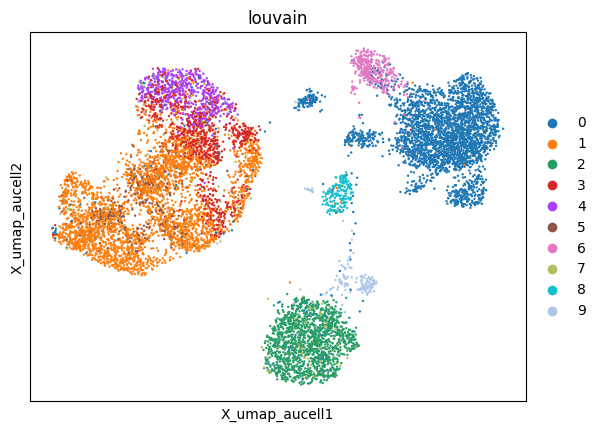

In [54]:
sc.pl.embedding(adata, basis="X_umap_aucell", color="louvain")

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


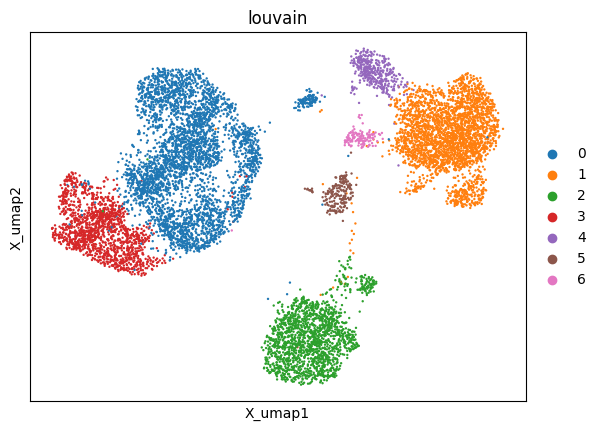

In [56]:
sc.tl.louvain(ad_auc_mtx, resolution=0.2)
sc.pl.embedding(ad_auc_mtx, basis="X_umap", color='louvain')

In [57]:
sc.tl.rank_genes_groups(ad_auc_mtx, 'louvain', method='t-test')

In [58]:
marker_genes = pd.DataFrame(ad_auc_mtx.uns["rank_genes_groups"]["names"])
marker_genes.columns = ["Cluster" + str(x) for x in range(0, len(ad_auc_mtx.obs["louvain"].unique()))]
marker_genes.head()

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6
0,PRDM1(+),SPI1(+),SPIB(+),MEOX1(+),TCF7L2(+),TAL1(+),CEBPB(+)
1,EOMES(+),NFE2(+),BCL11A(+),LEF1(+),SPI1(+),GATA1(+),SPI1(+)
2,TBX21(+),CEBPD(+),PAX5(+),TCF7(+),CEBPB(+),MAFG(+),NFE2(+)
3,RUNX3(+),CEBPB(+),IRF8(+),KLF12(+),MAFB(+),NFE2(+),GATA3(+)
4,KLF12(+),MAFB(+),IRF4(+),BACH2(+),E2F1(+),E2F1(+),CEBPD(+)


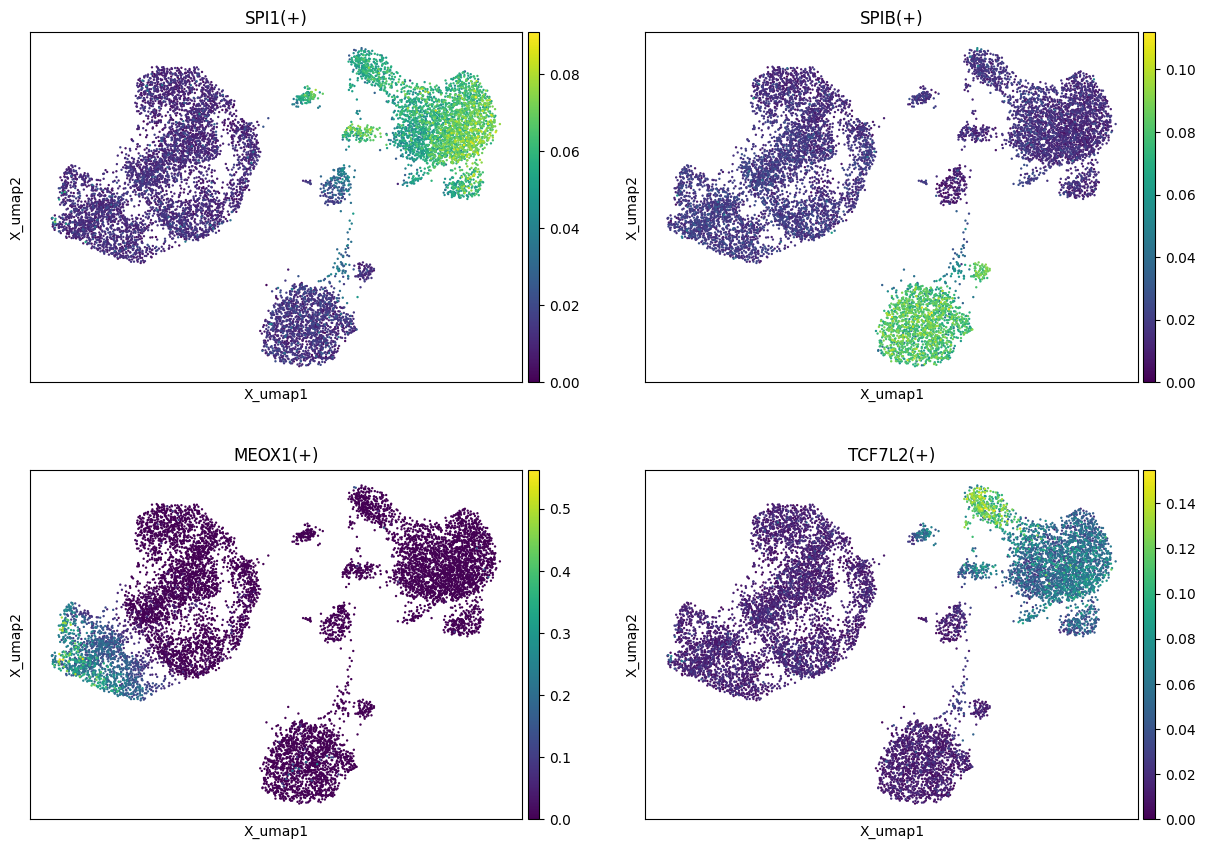

In [63]:
sc.pl.embedding(ad_auc_mtx, basis="X_umap", color=['SPI1(+)',
                                                  'SPIB(+)', 'MEOX1(+)', 'TCF7L2(+)'], ncols=2)